# Images to video with FFmpeg and Python

*Sidney Radcliffe | 29/06/2020*

This notebook contains some examples of creating videos with FFmpeg and Python.

Assumes [FFmpeg](https://ffmpeg.org/) is installed and in path (and up to date).

### Example ffmpeg command:

Turn a folder of images into a video: `ffmpeg -y -r 15 -i image_dir/%08d.jpg -r 30 out.mp4` (run from command line).

- -y <- overwrite existing out.mp4.
- left -r = input framerate.
- right -r = output framerate.
    - e.g. `-r 15 ... -r 30` means go through images at 15 per second, and put into video of 30 fps.
- %08d.jpg <- expect images to be named as 00000000.jpg, 00000001.jpg, ... (8 digits).
- out.mp4 <- sets output video filename and filetype

Images should be of same size. Width and height should be an even number of pixels.
Uses default encoding settings.

# Examples with Python:

In [1]:
import numpy as np
from PIL import Image
import subprocess, pathlib, shutil
from magic_timer import MagicTimer

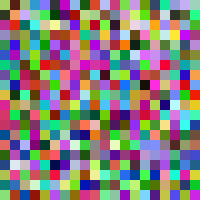

In [2]:
def create_image(w=20, h=20):
    return np.random.random((w, h, 3))

def numpy_to_pil(array): # array.shape=(w,h,3), range=0-1
    return Image.fromarray(np.uint8(array*255))

im = create_image()
im = numpy_to_pil(im).resize((200, 200))
display(im)

In [3]:
# Create directory to dump videos in:
pathlib.Path('dump/').mkdir(parents=True, exist_ok=True)

## Example 1: Save images to disk, create video, delete images.

In [4]:
t = MagicTimer()
IMAGE_DIR = pathlib.Path('tmp_images_for_ffmpeg/')
IMAGE_DIR.mkdir(parents=True, exist_ok=True)
for i in range(333):
    im = create_image()
    image = numpy_to_pil(im).resize((1280, 720))
    image.save(IMAGE_DIR / f'{i:08d}.jpg')
command = ['ffmpeg', '-y', '-r', '30', '-i', f'{IMAGE_DIR}/%08d.jpg', 
           '-r', '30', 'dump/out_from_images.mp4']
subprocess.run(command)
shutil.rmtree(IMAGE_DIR)  # delete images
print(f'Created video in {t}.')

Created video in 9.6 seconds.


## Example 2: stream directly to video.

Modified from: https://stackoverflow.com/a/13298538/4572034.

In [5]:
t = MagicTimer()
command = ['ffmpeg', '-y', '-f', 'image2pipe', 
           '-r', '30', '-i', '-', '-r', '30', 'dump/out_from_stream.mp4']
p = subprocess.Popen(command, stdin=subprocess.PIPE)
for i in range(333):
    im = create_image()
    image = numpy_to_pil(im).resize((1280, 720))
    image.save(p.stdin, 'JPEG')
p.stdin.close()
p.wait()
print(f'Created video in {t}.')

Created video in 7.4 seconds.


It may be worth saving images (and not deleting) if might later change rate / fps / size / quality.

## Example 2b: using a context manager.

Seems neater if want to do this more than once.

https://book.pythontips.com/en/latest/context_managers.html#implementing-a-context-manager-as-a-generator

In [6]:
from contextlib import contextmanager

@contextmanager
def steam_video(rate_in='30', out_fps='30', out='out.mp4'):
    command = ['ffmpeg', '-y', '-f', 'image2pipe', 
               '-r', rate_in, '-i', '-', '-r', out_fps, out]
    p = subprocess.Popen(command, stdin=subprocess.PIPE)
    try:
        yield p.stdin
    finally:
        p.stdin.close()
        p.wait()

t = MagicTimer()
with steam_video(out='dump/out_from_stream.mp4') as stdin:
    for i in range(333):
        im = create_image()
        image = numpy_to_pil(im).resize((1280, 720))
        image.save(stdin, 'JPEG')
print(f'Created video in {t}.')

Created video in 7.5 seconds.
